In [11]:
from SeismicReduction import *
import pickle

## Modify VaeModel to run either ADAM or SGD optimiser:

In [12]:
class VaeModelADAM(ModelAgent):
    """
    Runs the VAE model to reduce the seismic data to an arbitrary sized dimension, visualised in 2 via UMAP.
    """
    def __init__(self, data):
        super().__init__(data)
        self.name = 'VAE'

    def create_dataloader(self, batch_size=32):
        """
        Create pytorch data loaders for use in vae training, testing and running.

        Parameters
        ----------
        batch_size : int
            Size of data loader batches.

        Returns
        -------
        Modifies object data loader attributes.

        """
        # create torch tensor
        assert self.input.shape[1] == 2, 'Expected a three dimensional input with 2 channels'
        X = torch.from_numpy(self.input).float()

        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

        split = ShuffleSplit(n_splits=1, test_size=0.5)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset,
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset,
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      **kwargs)

    def train_vae(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse'):
        """
        Handles the training of the vae model.

        Parameters
        ----------
        epochs : int
            Number of complete passes over the whole training set.
        hidden_size : int
            Size of the latent space of the vae.
        lr : float.
            Learning rate for the vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation

        Returns
        -------
        None

        """
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size,
                         self.input.shape)  # Inititalize the model

        optimizer = optim.Adam(self.model.parameters(),
                               lr=lr,
                               betas=(0.9, 0.999))
    


        if self.plot_loss:
            liveloss = PlotLosses()
            liveloss.skip_first = 0
            liveloss.figsize = (16, 10)

        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch,
                       self.model,
                       optimizer,
                       self.train_loader,
                       recon_loss_method=recon_loss_method)  # Train model on train dataset
            testl = test(epoch, self.model, self.test_loader, recon_loss_method=recon_loss_method)

            if self.plot_loss:  # log train and test losses for dynamic plot
                logs = {}
                logs['' + 'ELBO'] = tl
                logs['val_' + 'ELBO'] = testl
                liveloss.update(logs)
                liveloss.draw()
            print('epoch', epoch)
        return testl

    def run_vae(self):
        """
        Run the full data set through the trained vae model.

        Returns
        -------
        Modifies the zs attribute, an array of shape (number_traces, latent_space)
        """
        _, zs = forward_all(self.model, self.all_loader)
        return zs.numpy()

    def reduce(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse', plot_loss=True):
        """
        Controller function for the vae model.

        Parameters
        ----------
        epochs : int
            Number of epochs to run vae model.
        hidden_size : int
            Size of the vae model latent space representation.
        lr : float
            Learning rate for vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation
        plot_loss : bool
            Control on whether to plot the loss on vae training.

        Returns
        -------
        Modifies embedding attribute via generation of the low dimensional representation.

        """
        if hidden_size < 2:
            raise Exception('Please use hidden size > 1')

        self.plot_loss = plot_loss  # define whether to plot training losses or not
        self.create_dataloader()

        if not self.loaded_model:
            loss = self.train_vae(epochs=epochs, hidden_size=hidden_size, lr=lr, recon_loss_method=recon_loss_method)

        self.embedding = self.run_vae()  # arbitrary dimension output from VAE
        
        return loss

In [13]:
class VaeModelSGDM(ModelAgent):
    """
    Runs the VAE model to reduce the seismic data to an arbitrary sized dimension, visualised in 2 via UMAP.
    """
    def __init__(self, data):
        super().__init__(data)
        self.name = 'VAE'

    def create_dataloader(self, batch_size=32):
        """
        Create pytorch data loaders for use in vae training, testing and running.

        Parameters
        ----------
        batch_size : int
            Size of data loader batches.

        Returns
        -------
        Modifies object data loader attributes.

        """
        # create torch tensor
        assert self.input.shape[1] == 2, 'Expected a three dimensional input with 2 channels'
        X = torch.from_numpy(self.input).float()

        # Create a stacked representation and a zero tensor so we can use the standard Pytorch TensorDataset
        y = torch.from_numpy(np.zeros((X.shape[0], 1))).float()

        split = ShuffleSplit(n_splits=1, test_size=0.5)
        for train_index, test_index in split.split(X):
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

        train_dset = TensorDataset(X_train, y_train)
        test_dset = TensorDataset(X_test, y_test)
        all_dset = TensorDataset(X, y)

        kwargs = {'num_workers': 1, 'pin_memory': True}
        self.train_loader = torch.utils.data.DataLoader(train_dset,
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        **kwargs)
        self.test_loader = torch.utils.data.DataLoader(test_dset,
                                                       batch_size=batch_size,
                                                       shuffle=False,
                                                       **kwargs)
        self.all_loader = torch.utils.data.DataLoader(all_dset,
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      **kwargs)

    def train_vae(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse', momentum=0.5):
        """
        Handles the training of the vae model.

        Parameters
        ----------
        epochs : int
            Number of complete passes over the whole training set.
        hidden_size : int
            Size of the latent space of the vae.
        lr : float.
            Learning rate for the vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation

        Returns
        -------
        None

        """
        set_seed(42)  # Set the random seed
        self.model = VAE(hidden_size,
                         self.input.shape)  # Inititalize the model
        
        optimizer = optim.SGD(self.model.parameters(), 
                              lr=lr, 
                              momentum=momentum)

        if self.plot_loss:
            liveloss = PlotLosses()
            liveloss.skip_first = 0
            liveloss.figsize = (16, 10)

        # Start training loop
        for epoch in range(1, epochs + 1):
            tl = train(epoch,
                       self.model,
                       optimizer,
                       self.train_loader,
                       recon_loss_method=recon_loss_method)  # Train model on train dataset
            testl = test(epoch, self.model, self.test_loader, recon_loss_method=recon_loss_method)

            if self.plot_loss:  # log train and test losses for dynamic plot
                logs = {}
                logs['' + 'ELBO'] = tl
                logs['val_' + 'ELBO'] = testl
                liveloss.update(logs)
                liveloss.draw()
                  
            print('epoch', epoch)


        return testl

    def run_vae(self):
        """
        Run the full data set through the trained vae model.

        Returns
        -------
        Modifies the zs attribute, an array of shape (number_traces, latent_space)
        """
        _, zs = forward_all(self.model, self.all_loader)
        return zs.numpy()

    def reduce(self, epochs=5, hidden_size=8, lr=1e-2, recon_loss_method='mse', plot_loss=True, momentum=0.5):
        """
        Controller function for the vae model.

        Parameters
        ----------
        epochs : int
            Number of epochs to run vae model.
        hidden_size : int
            Size of the vae model latent space representation.
        lr : float
            Learning rate for vae model training.
        recon_loss_method : str
            Method for reconstruction loss calculation
        plot_loss : bool
            Control on whether to plot the loss on vae training.

        Returns
        -------
        Modifies embedding attribute via generation of the low dimensional representation.

        """
        if hidden_size < 2:
            raise Exception('Please use hidden size > 1')

        self.plot_loss = plot_loss  # define whether to plot training losses or not
        self.create_dataloader()

        if not self.loaded_model:
            loss = self.train_vae(epochs=epochs, hidden_size=hidden_size, lr=lr, recon_loss_method=recon_loss_method, momentum=momentum)

        self.embedding = self.run_vae()  # arbitrary dimension output from VAE
        
        return loss

In [14]:
# load data
file_pi2 = open('../pickled/data.pickle', 'rb')
dataholder = pickle.load(file_pi2)
file_pi2.close()

In [15]:
### Processor
processor = Processor(dataholder)
input1 = processor(flatten=[True, 12, 52], normalise=True)

Processor has created an output with shape:  (25351, 2, 64)


# Optimiser testing:

In [16]:
vaeADAM = VaeModelADAM(input1)
vaeSGDM = VaeModelSGDM(input1)

ModelAgent initialised
ModelAgent initialised


### Adam:

/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
learningrate: 0.0001 loss 92.61451452031953
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8


epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
epoch 88
epoch 89
epoch 90
epoch 91
epoch 92
epoch 93
epoch 94
epoch 95
epoch 96
epoch 97
epoch 98
epoch 99
epoch 100
learningrate: 0.003 loss 92.68561365928662
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
epoch 51
epoch 52
epoch 53
epoch 54
epoch 55
epoch 56
epoch 57
epoch 58
epoch 59
epoch 60
epoch 61
epoch 62
epoch 63
epoch 64
epoch 65
epoch 66
epoch 67
epoch 68
epoch 69
epoch 70
epoch 71
epoch 72
epoch 73
epoch 74
epoch 75
epoch 76
epoch 77
epoch 78
epoch 79
epoch 80
epoch 81
epoch 82
epoch 83
epoch 84
epoch 85
epoch 86
epoch 87
ep

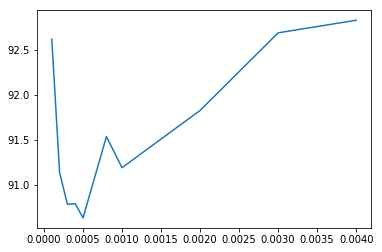

In [8]:
lrs = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0008, 0.001, 0.002, 0.003, 0.004]
adamlosses = []
for i in lrs:
    adamloss = vaeADAM.reduce(epochs=200, hidden_size=8, lr=i, plot_loss=False)
    print('learningrate:', i, 'loss', adamloss)
    adamlosses.append(adamloss)

plt.plot(lrs, adamlosses)

In [10]:
plt.savefig('/Users/hugocoussens/OneDrive - Imperial College London/MSc_Project/Adamlrs.png')

<Figure size 432x288 with 0 Axes>

# Plot the losses of Adam with lr=0.0005 vs lr=0.01:

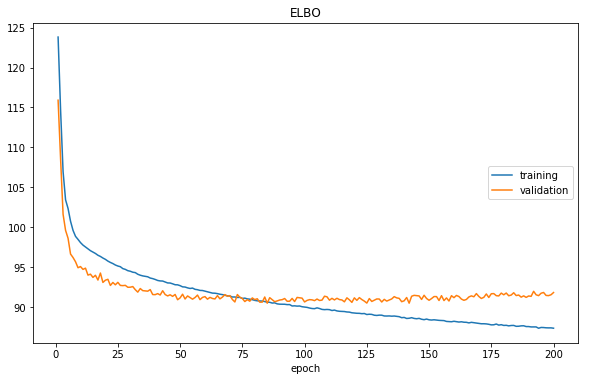

ELBO:
training   (min:   87.335, max:  123.817, cur:   87.340)
validation (min:   90.472, max:  115.905, cur:   91.808)
epoch 200


91.80837400225143

In [188]:
vaeADAM.reduce(epochs=300, hidden_size=2, lr=0.0005, plot_loss=True)

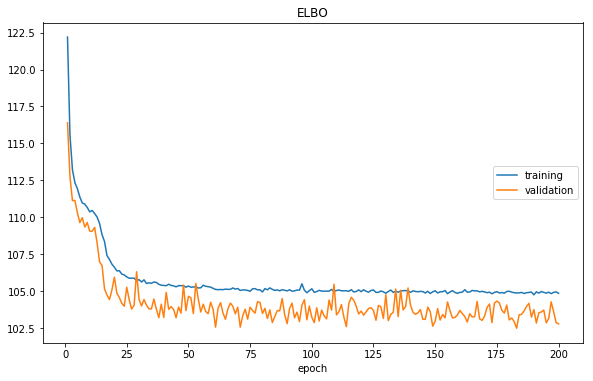

ELBO:
training   (min:  104.773, max:  122.193, cur:  104.874)
validation (min:  102.512, max:  116.395, cur:  102.806)
epoch 200


102.80633393730339

In [189]:
vaeADAM.reduce(epochs=300, hidden_size=2, lr=0.01, plot_loss=True)

# SGD with momentum test:

In [130]:
momentums = [0.01, 0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.99]
lrs = [0.00005, 0.0001, 0.0002, 0.0004]
sgdlosses = np.zeros((len(momentums),len(lrs)))

for i in momentums:
    for lr in lrs:
        sgdloss = vaeSGDM.reduce(epochs=300, hidden_size=2, lr=lr, plot_loss=False, momentum=i)
        print('momentum:', i, 'lr', j, 'loss:', sgdloss)
        sgdlosses[i, j] = sgdloss

/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
momentum: 0.01 lr 5e-05 loss: 93.42645517423274
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
momentum: 0.01 lr 0.0001 loss: 91.84132317843667
epoch 1
epoch 2
epoch

epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
momentum: 0.6 lr 5e-05 loss: 90.90321657295745
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
momentum: 0.6 lr 0.0001 loss: 91.63406882462121
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch

epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
momentum: 0.99 lr 0.0001 loss: 133.21147659894004
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
epoch 40
epoch 41
epoch 42
epoch 43
epoch 44
epoch 45
epoch 46
epoch 47
epoch 48
epoch 49
epoch 50
momentum: 0.99 lr 0.0002 loss: nan
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 

In [156]:
grid = sgdlosses
print(grid)

[[ 93.42645517  91.84132318  91.02112757  96.64236072]
 [ 92.54247954  91.36528081  92.24761593  95.17619323]
 [ 92.30215652  91.28628294  91.4038301   99.00229908]
 [ 91.16809689  92.05758361  92.08380416  96.39872294]
 [ 90.90321657  91.63406882  93.71944295 106.47976769]
 [ 90.60159736  91.48838443  96.40822481 105.72608942]
 [ 91.58261651  92.88393442 101.09370685 122.19854465]
 [ 94.03041072 100.97061276 117.0285178  132.89545903]
 [133.20967762 133.2114766           nan 133.38132053]]


# Plot the parameter grid search ELBO performance

(9, 4) (8, 4) (8, 4)


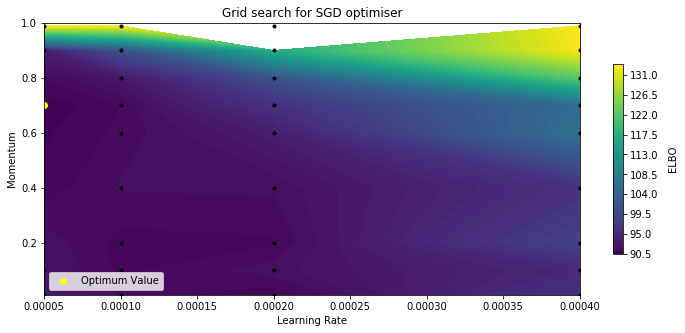

In [187]:
X, Y = np.meshgrid(lrs, momentums)
T = grid
print(grid.shape, xv.shape, yv.shape)
x = lrs
y = momentums
# Choose npts random point from the discrete domain of our model function

from scipy.interpolate import griddata
fig, ax = plt.subplots(figsize=(12, 5))
# Plot the model function and the randomly selected sample points
contour = ax.contourf(X, Y, T, 100)
scatter = ax.scatter(X, Y, c='k', alpha=1, marker='.')
scatter = ax.scatter(0.00005, 0.7, alpha=1, marker='o', color='yellow', label='Optimum Value')
cbar = plt.colorbar(contour, shrink=0.7, orientation='vertical')
cbar.set_label(label='ELBO', rotation=90, labelpad=10)
ax.legend(loc='lower left')
ax.set_ylabel('Momentum')
ax.set_xlabel('Learning Rate')
ax.set_title('Grid search for SGD optimiser')
ax.set_xlim(0.00005, 0.0004)
ax.set_ylim(0.01, 1)

plt.show()

# Plot the losses of SGD with lr=0.00005 vs lr=0.01

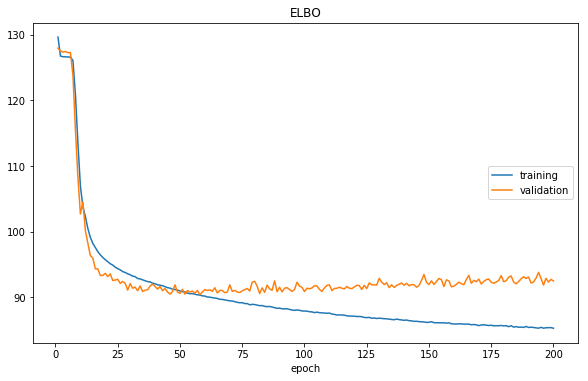

ELBO:
training   (min:   85.295, max:  129.632, cur:   85.295)
validation (min:   90.411, max:  127.941, cur:   92.492)
epoch 200


In [17]:
sgdloss = vaeSGDM.reduce(epochs=300, hidden_size=2, lr=0.00005, plot_loss=True, momentum=0.7)

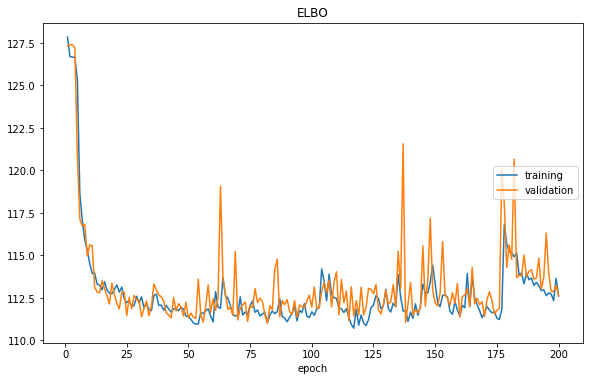

ELBO:
training   (min:  110.711, max:  127.838, cur:  112.605)
validation (min:  111.014, max:  127.393, cur:  112.629)
epoch 200


In [21]:
sgdloss = vaeSGDM.reduce(epochs=300, hidden_size=2, lr=0.0001, plot_loss=True, momentum=0.7)